### Random forest

In [60]:
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

In [61]:
# Load Data
%store -r X_train X_test y_train y_test X_train_pca X_test_pca
%store -r koi_reduced_df reduced_df

In [62]:
X_train_pca = X_train_pca.copy()
X_test_pca = X_test_pca.copy()
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()
print(y_train)
print(y_test)
print(X_train)
print(X_test)
print(X_train_pca)
print(X_test_pca)

981     2
1153    1
2401    2
674     2
468     2
       ..
2895    1
2763    2
905     2
3980    1
235     2
Name: koi_disposition, Length: 2323, dtype: int64
4377    1
2457    2
3248    1
2340    1
62      2
       ..
2259    2
2026    2
4546    1
4310    1
1445    2
Name: koi_disposition, Length: 2324, dtype: int64
      koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth  koi_prad   
981     2.248288   133.425805      0.0040        2.0361      263.2      1.25  \
1153  124.035899   136.015098      0.0750        4.8472     7690.0     11.13   
2401    7.071361   139.987630      0.6580        2.7570       65.7      0.63   
674     2.240487   137.824770      0.4610        1.3988      436.3      1.22   
468     6.186709   136.633080      0.0130        2.9090      202.6      1.21   
...          ...          ...         ...           ...        ...       ...   
2895   41.675751   169.791000      0.2560       10.8480      142.0      2.10   
2763    9.478508   140.165260      0.112

In [63]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10000,n_jobs = -1, random_state=1,class_weight='balanced') #参数根据需求调整
rf.fit(X_train_pca, y_train)

y_pred = rf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


### Find the best parameter

In [64]:
# use the random forest classifier to predict the test data
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create a random forest classifier
rf = RandomForestClassifier()
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                param_dist, 
                        		n_iter = 100, 
                        		cv = 3, 
                        		verbose = 1, 
                        		n_jobs=-1, 
                        		random_state=0)
# Fit the random search object to the data
rand_search.fit(X_train_pca, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters: {'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False}


In [65]:
# drop irrelevant columns
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
rs_df = rs_df.drop([ 
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time', 
            'std_score_time', 
            'params' , 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'], 
            axis=1) 
rs_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,12,2,sqrt,13,False,0.709859,1
1,700,23,7,log2,15,False,0.709431,2
2,500,18,7,log2,7,True,0.709428,3
3,600,23,2,sqrt,15,False,0.708998,4
4,700,23,12,sqrt,8,True,0.705553,5
...,...,...,...,...,...,...,...,...
95,600,28,2,sqrt,1,False,0.650026,96
96,400,2,23,log2,1,False,0.648734,97
97,200,39,44,sqrt,1,True,0.647872,98
98,100,18,12,sqrt,1,False,0.647007,99


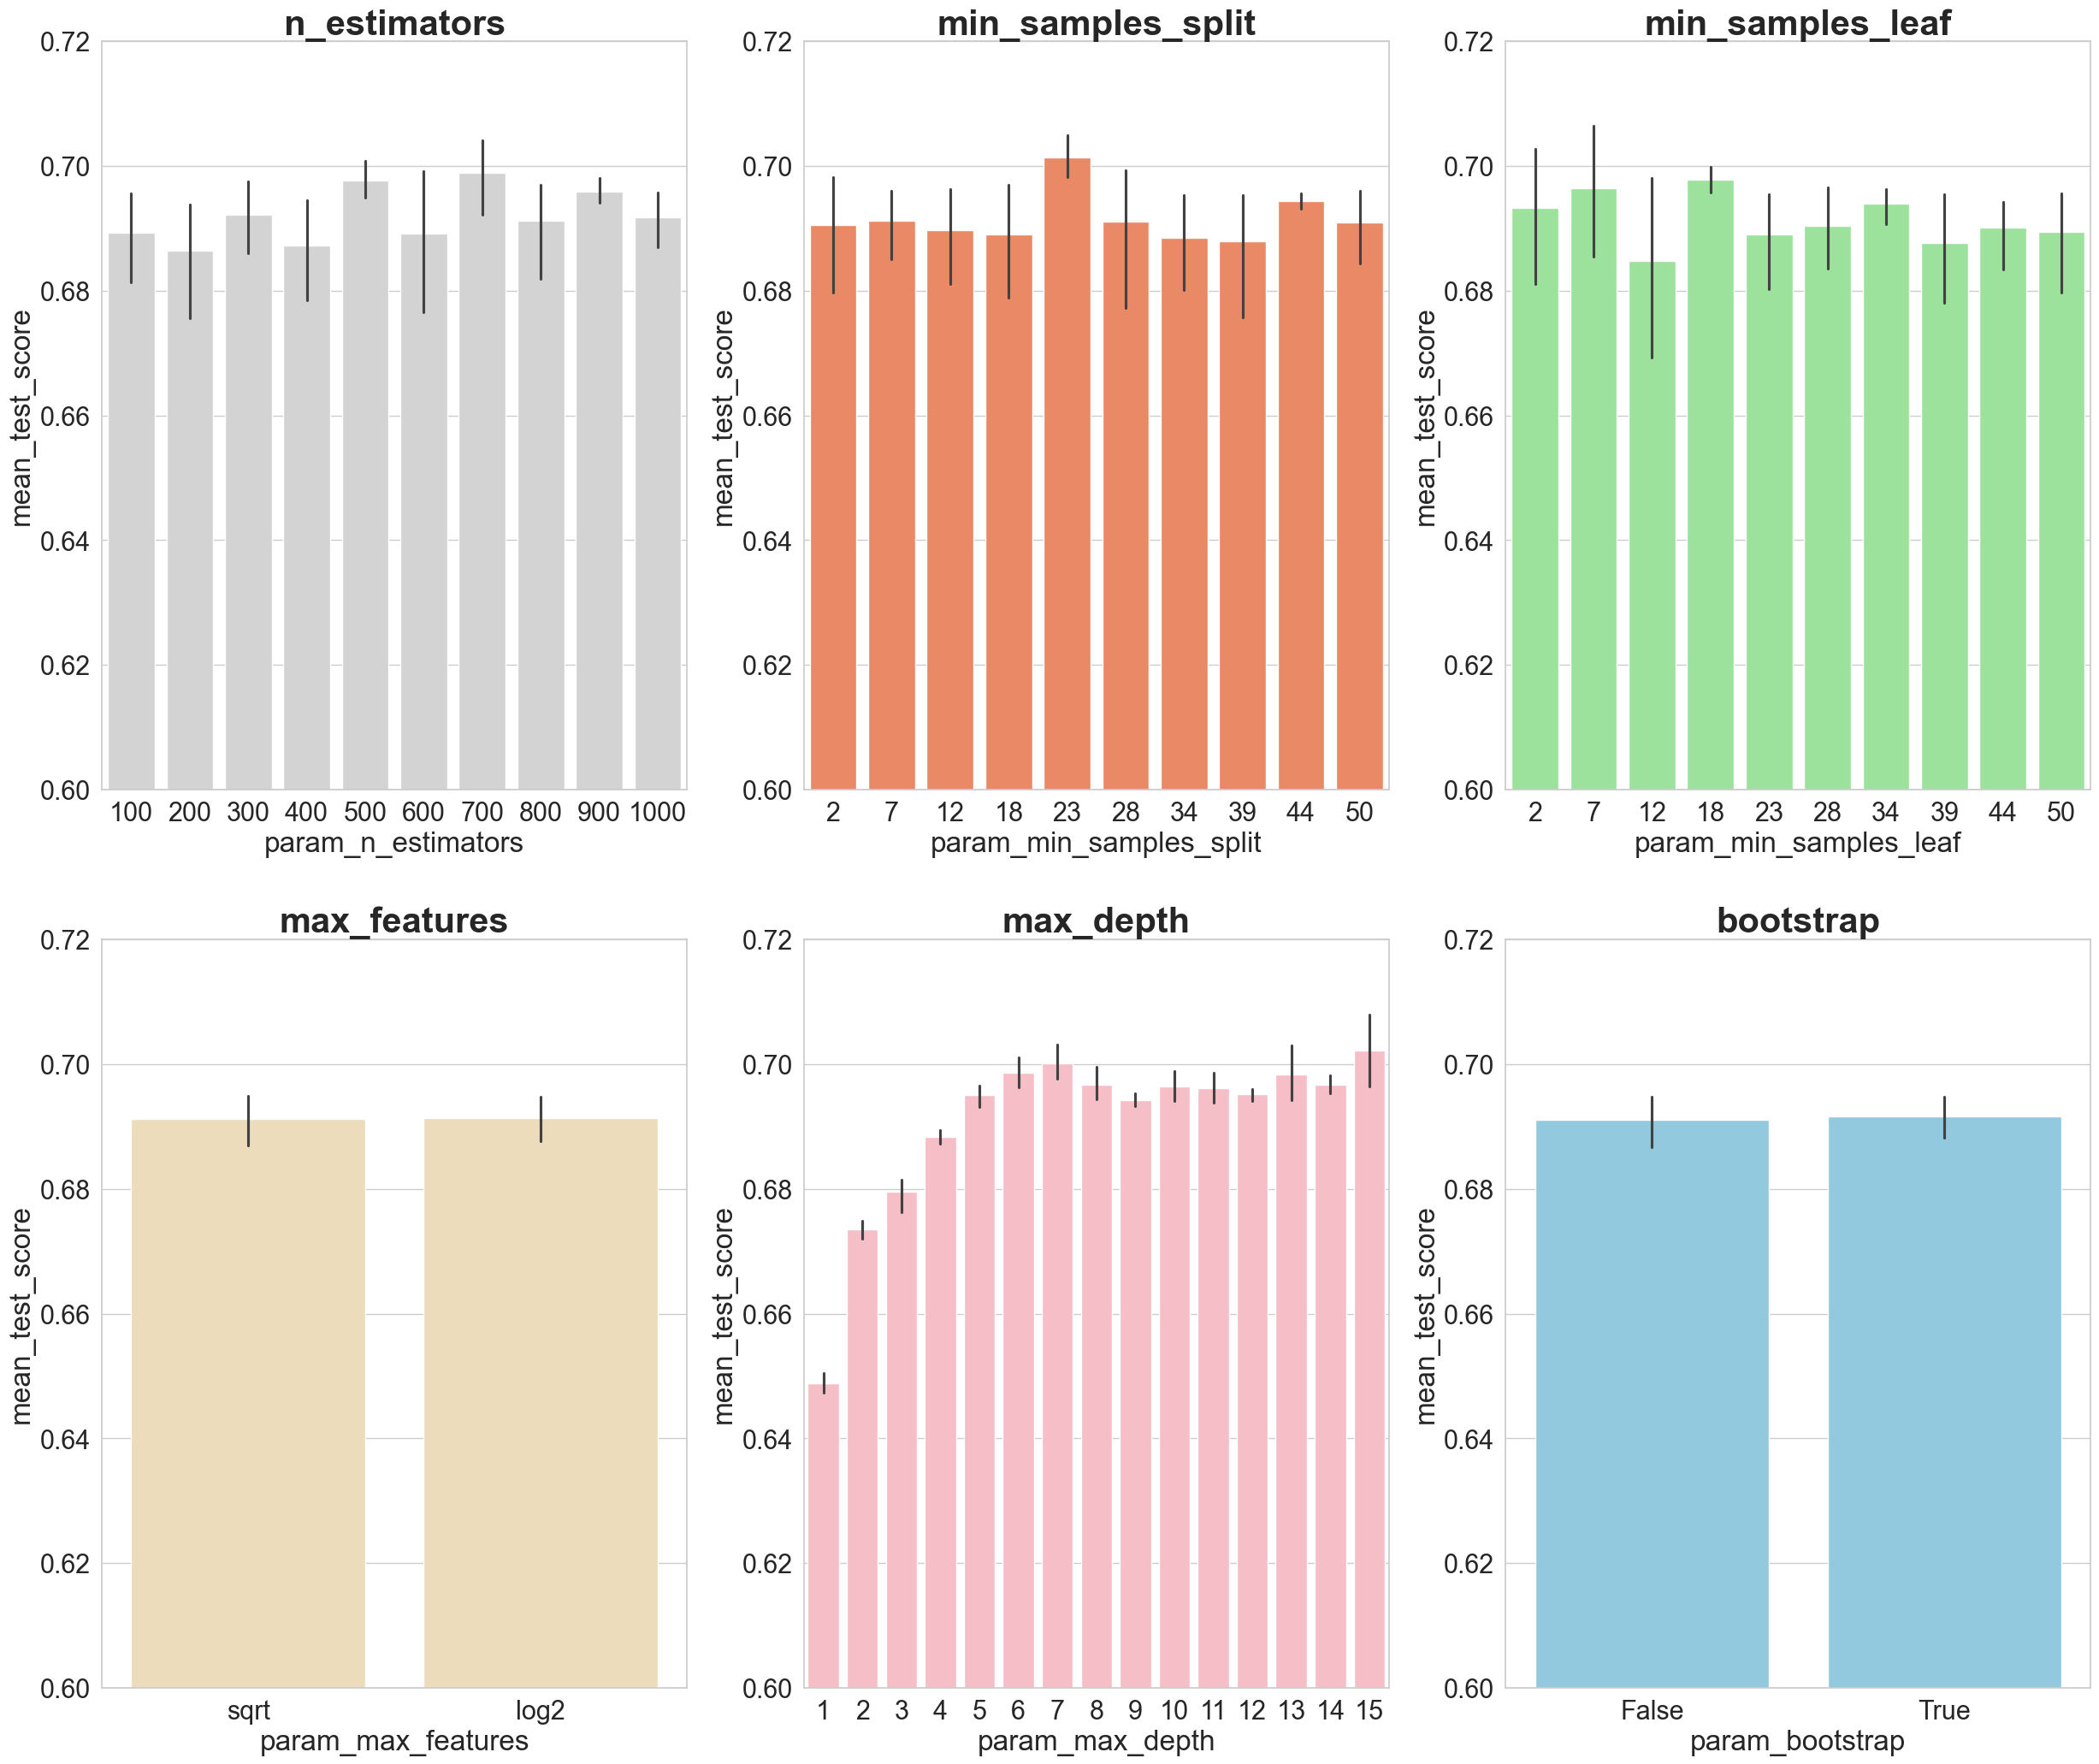

In [66]:
# Plot the hyperparameters
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.60,.72]); axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.60,.72]); axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.60,.72]); axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.60,.72]); axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.60,.72]); axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.60,.72])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [67]:
# use grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV
n_estimators = [500,700,900]
max_features = ['sqrt','log2']
max_depth = [6,7,15]
min_samples_split = [7,23,44,50]
min_samples_leaf = [2,7,18]
bootstrap = [True,False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rf, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 700}

In [68]:
# predict the test data
y_pred_pca = rand_search.predict(X_test_pca) 
y_pred_gs = gs.best_estimator_.predict(X_test_pca)

In [69]:
# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
display(conf_matrix_baseline_pca)
display(conf_matrix_tuned_pca)
display('Baseline Random Forest With PCA recall score', recall_score(y_test, y_pred_pca, average='weighted'))
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test, y_pred_gs, average='weighted'))

,predicted 0,predicted 1,predicted 2
actual 0,0,20,4
actual 1,0,522,417
actual 2,0,195,1166


,predicted 0,predicted 1,predicted 2
actual 0,1,19,4
actual 1,0,552,387
actual 2,0,223,1138


'Baseline Random Forest With PCA recall score'

0.7263339070567987

'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score'

0.7276247848537005

In [70]:
# F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_gs, average='weighted') 
print("F1: ", f1)

F1:  0.7194286453289586


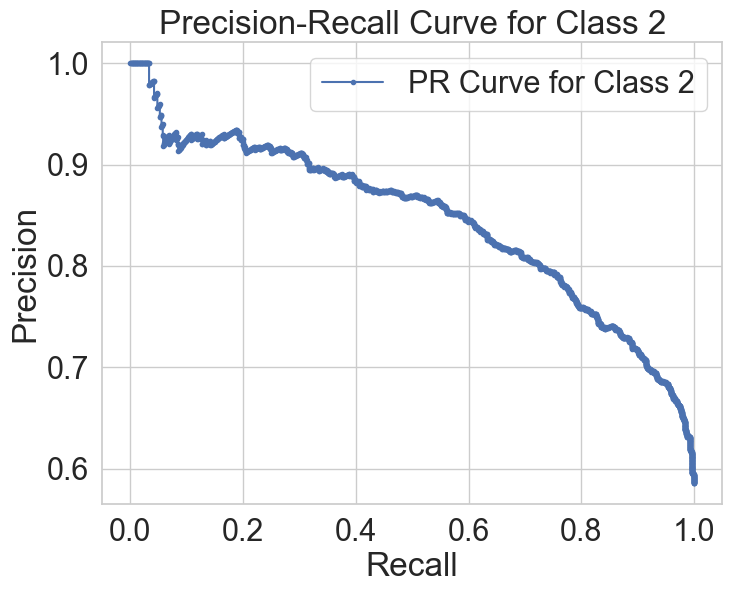

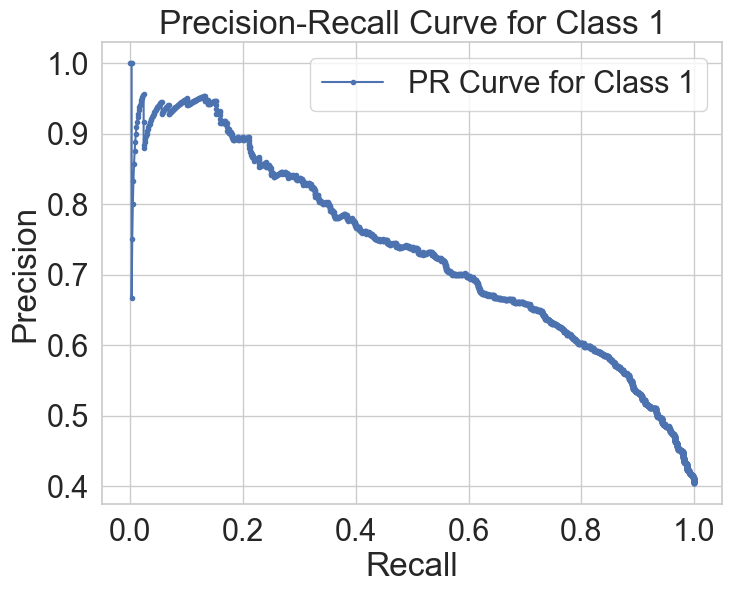

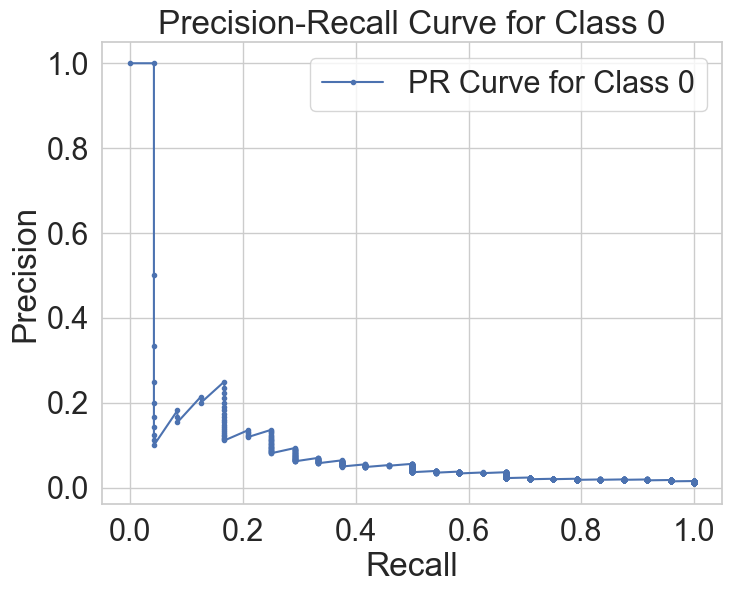

In [71]:
# per class precision and recall
y_pred_proba = gs.best_estimator_.predict_proba(X_test_pca)
y_pred_proba_class2 = y_pred_proba[:, 2] 
y_test_binary = (y_test == 2).astype(int)
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_class2)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve for Class 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 2')
plt.legend()
plt.grid(True)
plt.show()

y_pred_proba_class1 = y_pred_proba[:, 1]
y_test_binary = (y_test == 1).astype(int)
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_class1)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve for Class 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1')
plt.legend()
plt.grid(True)
plt.show()

y_pred_proba_class0 = y_pred_proba[:, 0]
y_test_binary = (y_test == 0).astype(int)
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_class0)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve for Class 0')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 0')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scaler = StandardScaler()
# X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)

# pca = PCA()
# pca.fit(X_train_resampled_scaled)
# explained = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
# print(cumulative_explained_variance)
# # apply PCA to the training data
# pca = PCA(n_components=8)
# X_train_pca = pca.fit_transform(X_train_resampled_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [73]:
# # Random Forest with PCA
# rf = RandomForestClassifier(n_estimators=10000,n_jobs = -1, random_state=1)
# rf.fit(X_train_pca, y_train_resampled)

# y_pred = rf.predict(X_test_pca)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")